# Методы обнаружения выбросов

*Подготовил Ян Пиле*

Что такое выброс?

<img src="https://miro.medium.com/max/1000/1*O3lOgPwuHP7Vfc1T6NDRrQ.png">

Обычно выбросами называют такие точки в ваших данных, которые в некотором смысле далеки от всех остальных. Говоря чуть более формально, выбросы - такие наблюдения, которые "не вписываются" в общее распределение данных или находятся близко к краям этого распределения. Уверен, все ввидели подобные картинки.

# Откуда берутся выбросы?


### Человеческие ошибки 

Обычно это ошибки ввода данных. Часто такие ошибки можно встретить, например, в банковских данных. Представьте, что работник отделения банка заполняет данные о новом клиенте в CRM и, скажем, при заполнении поля "Возраст" случайно проставляет дополнительный ноль. Так могут "появиться" клиенты с возрастом > 200 лет.

### Инструментальные ошибки
Если вы собираетесь прогнозировать временной ряд изменений температуры, используя для этого поминутные показания, снятые с [термопары](https://ru.wikipedia.org/wiki/Термопара), закрепленной на улице, но при этом контакты термопары со временем окисляются (а это вносит ошибку в измерение), можно получить незапланированные отклонения 


### Ошибки проведения эксперимента 
Представим, что вы решили собрать обучающую выборку для модели преобразования речи в текст и для этого в течение всего дня записывали аудиофрагменты речи членов своей семьи. В конце концов вы решили записать свою речь и тут ваш сосед сверху начал сверлить стену перфоратором. На аудиозаписи возникнет набор частот, значительно отличающийся от стандартной человеческой речи. Более того, звуки перфоратора скорее всего заглушат вашу речь. Почему это ошибка проведения эксперимента? Вы не удостоверились, что не будет источника паразитного шума.

### Ошибки обработки данных
Представим, что вы DS, за которого обучающую выборку собирает ваш коллега, специально обученный человек (я такого не видел). Пусть данные собираются последовательностью толстых SQL-запросов с большим количество join'ов. В ходе одного из таких join'ов ваш коллега пишет:

    select a.*, coalesce(b.income, -9999) as income
    from left_table as a 
    left join right_table as b 
    on a.user_id = b.user_id
    
Если по кому-то из пользователей в right_table доход отсутствует, в ваших результирующих данных образуются пользователи с отрицательным доходом равным -9999. С точки зрения распределения доходов отрицательное число будет выглядеть достаточно странным. 
    
### Ошибки сэмплирования
Вы почти всегда пытаетесь оцнивать параметры генеральной совокупности по выборке. Может так случиться, что при формировании выборка сформировалась не вполне отражающей характеристики генеральной совокупности. Например, если у вас есть мешок с 5 черными, 8 зелеными, 5 белыми и 2 синими шариками и вы хотите получить выборку длины 20 с возвращением, с вероятностью $10^-20$ вы получите выборку из 20 синих шариков. Случай, конечно, утрированный, но суть ясна.

### Явления, не описывающиеся вашей теорией
Поиск таких отклонений - важная работа во многих науках. Это наблюдение явлений, которые на данный момент не имеют объяснения, но и не являются ошибкой. Например такое можно встретить в обработке данных с Большого Адронного Коллайдера (поиск новой физики).  Например в в 19 веке Урбен Леверье [измерил](https://ru.wikipedia.org/wiki/Смещение_перигелия_Меркурия) смещение [перигелия](https://ru.wikipedia.org/wiki/Перигелий) Меркурия и обнаружил значимое смещение в 43 угловые минуты за столетие. Это стало одним из толчков к созданию Общей Теории Относительности. (Надеюсь, что в этот момент вы не настроились за каждым выбросом в данных о выручке искать инопланетян) 



# Где возникают проблемы из-за выбросов?

## Статистические тесты для сравнения величин, базирующихся на суммах.

Если вы собрались в двух выборках сравнивать средние значения (как оценки математического ожидания) или выборочные дисперсии, и в наблюдениях имеют место выбросы, готовьтесь получить не то, что вы хотите.

In [329]:
import numpy as np
from scipy import stats

In [331]:
X1 = stats.norm.rvs(loc=10, scale=2, size=(900,1000))
X2 = stats.norm.rvs(loc=10, scale=2, size=(900,1000))

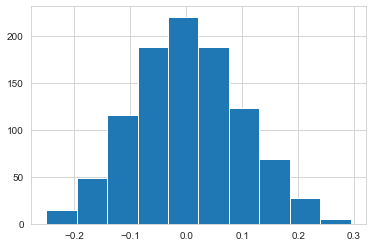

In [332]:
_ = plt.hist(X2.mean(axis=0) - X1.mean(axis=0))

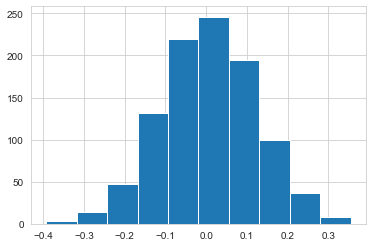

In [333]:
_ = plt.hist(np.median(X2,axis=0) - np.median(X1,axis=0))

In [334]:
X1 = stats.norm.rvs(loc=10, scale=2, size=(900,1000))
X2 = stats.norm.rvs(loc=10, scale=2, size=(896,1000))
X2 = np.vstack((X2,2000*np.ones((4, 1000))))

Средние теперь отличаются. 

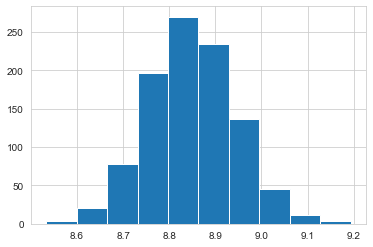

In [335]:
_ = plt.hist(X2.mean(axis=0) - X1.mean(axis=0))

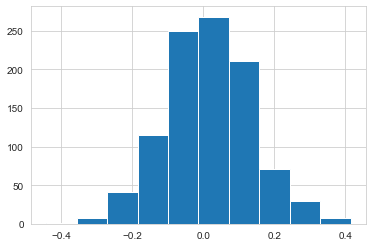

In [336]:
_ = plt.hist(np.median(X2,axis=0) - np.median(X1,axis=0))

## Модели, прогнозирующие величину в смысле среднего арифметического 
### (например линейная регрессия)

In [337]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/abjidge/The-Complete-Guide-to-Linear-Regression-Analysis-with-Business-Problem/master/Advertising.csv', index_col=0)

In [338]:
print('df вида', df.shape)
df.head(5)

df вида (200, 4)


,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Text(0.5, 0, 'newspaper Advertising')

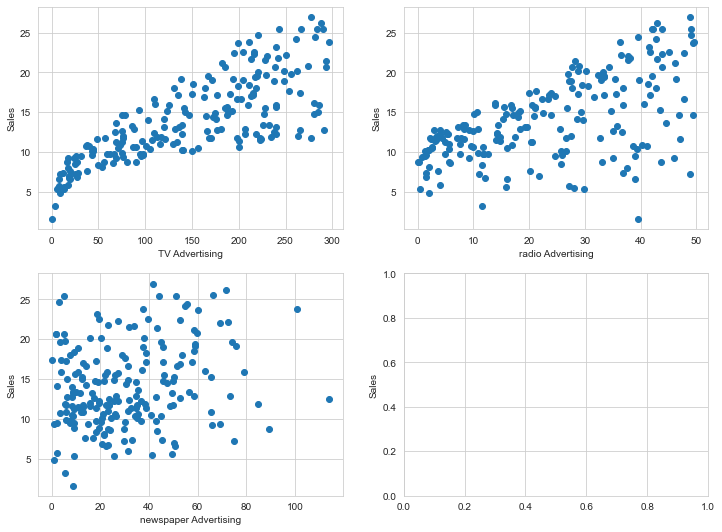

In [339]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize = (12,9))

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('Sales')
        
ax[0,0].scatter(x= df['TV'],y=df['sales'])
ax[0,1].scatter(x= df['radio'],y=df['sales'])
ax[1,0].scatter(x= df['newspaper'],y=df['sales'])
ax[0,0].set_xlabel('TV Advertising')
ax[0,1].set_xlabel('radio Advertising')
ax[1,0].set_xlabel('newspaper Advertising')

О какой-нибудь линейной зависимости от признаков я бы тут говорить не стал и мы, в общем-то, не линейной регрессией тут занимаемся :) Давайте возьмем информацию о рекламе на радио и ТВ, возможно немного линеаризуем ее и построим на этих двух переменных регрессию на продажи

Text(0.5, 0, 'sqrt radio Advertising')

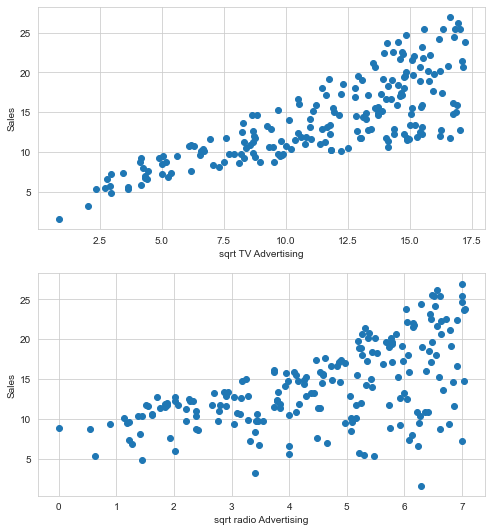

In [340]:
import numpy as np 

df['sqrt_tv'] = df['TV'].apply(lambda x: np.sqrt(x))
df['sqrt_radio'] = df['radio'].apply(lambda x: np.sqrt(x))
fig, ax = plt.subplots(2,1, figsize = (8,9))

for i in range(2):
    ax[i].set_ylabel('Sales')
        
ax[0].scatter(x= df['sqrt_tv'],y=df['sales'])
ax[1].scatter(x= df['sqrt_radio'],y=df['sales'])
ax[0].set_xlabel('sqrt TV Advertising')
ax[1].set_xlabel('sqrt radio Advertising')


In [341]:
from sklearn.linear_model import LinearRegression

In [342]:
reg = LinearRegression().fit(df[['sqrt_tv','sqrt_radio']], df['sales'])
df['sqrt_model'] = reg.predict(df[['sqrt_tv','sqrt_radio']])

reg2 = LinearRegression().fit(df[['TV','radio']], df['sales'])
df['model'] = reg2.predict(df[['TV','radio']])

In [343]:
df

,TV,radio,newspaper,sales,sqrt_tv,sqrt_radio,sqrt_model,model
1,230.1,37.8,69.2,22.1,15.169047,6.148170,20.281362,20.555465
2,44.5,39.3,45.1,10.4,6.670832,6.268971,12.241063,12.345362
3,17.2,45.9,69.3,9.3,4.147288,6.774954,10.592339,12.337018
4,151.5,41.3,58.5,18.5,12.308534,6.426508,17.948522,17.617116
5,180.8,10.8,58.4,12.9,13.446189,3.286335,14.115098,13.223908
...,...,...,...,...,...,...,...,...
196,38.2,3.7,13.8,7.6,6.180615,1.923538,4.936891,5.364512
197,94.2,4.9,8.1,9.7,9.705668,2.213594,8.806613,8.152375
198,177.0,9.3,6.4,12.8,13.304135,3.049590,13.605449,12.768048
199,283.6,42.0,66.2,25.5,16.840428,6.480741,22.422699,23.792923


Я здесь не позаботился о том, чтобы отнормировать признаки, но представим, что наши признаки совершенно равнозначны.

In [344]:
print('Среднеквадратичная ошибка модели с корнем',
      np.sum((df['sales']-df['sqrt_model'])**2)/df.shape[0])
print('Среднеквадратичная ошибка модели без корня',
      np.sum((df['sales']-df['model'])**2)/df.shape[0],'\n')

print('Средняя абсолютная ошибка модели с корнем',
      np.sum(np.abs(df['sales']-df['sqrt_model']))/df.shape[0])
print('Средняя абсолютная  ошибка модели без корня',
      np.sum(np.abs(df['sales']-df['model']))/df.shape[0])

Среднеквадратичная ошибка модели с корнем 2.4891042086809083
Среднеквадратичная ошибка модели без корня 2.784569900338091 

Средняя абсолютная ошибка модели с корнем 1.2037125883087074
Средняя абсолютная  ошибка модели без корня 1.2537471644234008


In [345]:
x=np.arange(0,26,0.5)
y=np.arange(0,26,0.5)

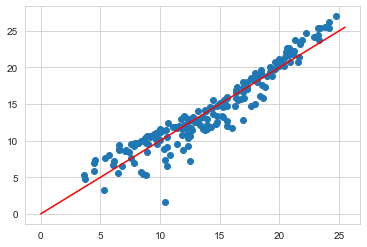

In [346]:
plt.scatter(x=df["model"], y=df["sales"])
plt.plot(x,y, c ='red')

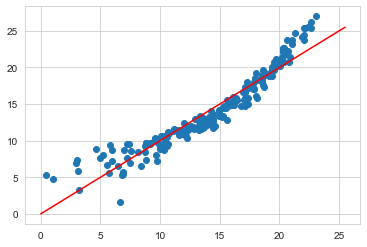

In [347]:
plt.scatter(x=df["sqrt_model"], y=df["sales"])
plt.plot(x,y, c ='red')

Испортим данные, добавив туда нехарактерное значение, скажем, признак TV == 2000 (при создании датасета случайно вбили два лишних нуля) при Sales = 5

In [348]:
add = pd.DataFrame([{'TV': 2000, 'radio': 45.9, 'newspaper': 69.3, 'sales': 5}])

In [349]:
df = pd.read_csv('https://raw.githubusercontent.com/abjidge/The-Complete-Guide-to-Linear-Regression-Analysis-with-Business-Problem/master/Advertising.csv', index_col=0)
df= df.append(add)

In [350]:
df.tail(5)

,TV,radio,newspaper,sales
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5
200,232.1,8.6,8.7,13.4
0,2000.0,45.9,69.3,5.0


In [352]:
reg2 = LinearRegression().fit(df[['TV','radio']], df['sales'])
df['model'] = reg2.predict(df[['TV','radio']])

In [353]:
print('Среднеквадратичная ошибка модели без корня',
      np.sum((df['sales']-df['model'])**2)/df.shape[0],'\n')

print('Средняя абсолютная  ошибка модели без корня',
      np.sum(np.abs(df['sales']-df['model']))/df.shape[0])

Среднеквадратичная ошибка модели без корня 17.066742308889335 

Средняя абсолютная  ошибка модели без корня 2.8502419138635537


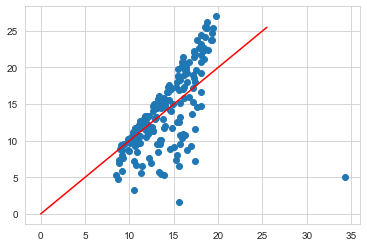

In [354]:
plt.scatter(x=df["model"], y=df["sales"])
plt.plot(x,y, c ='red')

Вот все и испортилось :(

# Про методы

Большинство методов обнаружения выбросов моделируют "нормальные" данные (в смысле не-выбросы), а все остальное называют выбросами. Мы разберем визуальный метод анализа ящика с усами и два связанных метода моделирования выбросов (а не нормальных данных), а заодно, позволяя себе некоторые вольности, разберемся с метрикой "нормальности" точки в IsolationForest

# Графическое обнаружение и boxplot. Откуда взялись 1.5 IQR

Кажется, что наша точка имеет достаточно экстремальное значение признака TV и эту точку можно быстро найти и, например, убить. В этом может помочь старый-добрый ящик с усами в простонародье известный как боксплот. Там есть какая-то присказка про то, что "за пределами усов" точки можно назвать выбросами. Вот давайте посмотрим, насколько мы сможем отловить выбросы таким методом и заодно разберемся, откуда взялось правило про длину этих усов.

<img src="https://miro.medium.com/max/1246/1*0MvBAT8zFSOt6sfEojbI-A.png">

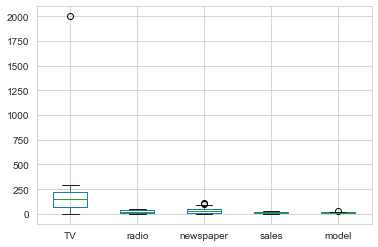

In [355]:
df.boxplot()

Вот странное значение и нашлось. Обычно за этим надо следить при построении моделей. 

### Почему 1.5 IQR

Вспомним нормальное распределение:
<img src="https://miro.medium.com/max/1400/1*ARpoeY3MdhFImq0JXAXtRw.png">

и еще один факт о нем - $Q1 = -0.675\sigma$ a $Q3 = 0.675\sigma$

Поехали считать, сколько процентов наблюдений будет между  $Q1 - n*IQR$ и  $Q3 + n*IQR$

Если взять $n=1$, то 


$$Q1 - 1 * IQR = Q1 - 1 * (Q3 - Q1) = -0.675\sigma - 1 * (0.675 - [-0.675])\sigma = -0.675σ - 1 * 1.35\sigma = -2.025\sigma$$


$$Q3 + 1 * IQR = Q3 + 1 * (Q3 - Q1) = 0.675\sigma + 1 * (0.675 - [-0.675])\sigma = 0.675σ + 1 * 1.35\sigma = 2.025\sigma$$

Тогда почти 5% наблюдений будут названы выбросами. Кажется, что многовато, почему-то мы решили, что примерно до $3\sigma$ наблюдения полезны.

Таким перебором можно обнаружить, что для получения $3\sigma$ надо взять $n = 1.7$, но это "как-то несимметрично", поэтому взяли 1.5 

### Ответ:

1) Потому что мы хотели бы для нормальной выборки записывать в выбросы не слишком много объектов

2) Потому что мы любим "симметрию" и красивые числа

# Isolation Forest

Этот алгоритм использует идеи случайного леса для присвоения точкам "скора" нормальности. Представим дерево, которое на каждом шаге выбирает случайный признак и случайное значение этого признака (из интервала от минимума до максимума выбранного признака), а остальную выборку делит пополам - та часть, у которой значения признака больше, и та, у которой меньше. Так дерево можно строить рекурсивно до какой-то наперед заданной глубины или пока все не переберется. Такое дерево называется "Изоляционным" деревом или iTree. А теперь магия: если выброс - точка, которая "выпадает" из общего распределения, то она в таком дереве будет находиться выше, чем средняя "нормальная" точка. 

Иллюстрация:

<img src="https://miro.medium.com/max/1400/1*ujfv7WJH-tL1cRLxYEoicg.png">

Наше дерево как будто бы набрасывает прямые, параллельные координатным осям (нашим признакам) в пространство и тем самым делит его на сегменты. Теперь можно построить лес из таких деревьев. Тогда для каждого дерева нужно взять не весь набор точек, а его подмножество фиксированного размера. Осталось только разобраться, как измерить, что считается аномальным, а что нормальным. 

### Формула:

$$score = e^{-\dfrac{E(h(n))}{c(n)}}$$

$E(h(n))$ - усредненная по всем деревьям длина пути до точки 

$с(n)$ - средняя длина пути до точки (в бинарных деревьях поиска эта штука известна как "средняя длина неудачного поиска")

$c(n) = 2H_{n-1}-\dfrac{2(n-1)}{n}$

$H_{n-1}$ - гармоническое число


Если скор близок к 0, то точка аномальная, если близок к 1, то нормальная. Отсечку часто ставят на значении 0.5.

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Обучение
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])

# Нормальные наблюдения
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])

# Выбросы
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

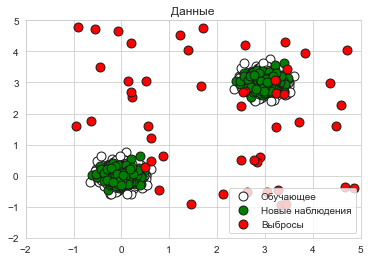

In [357]:
# Рисовалка
plt.title("Данные")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green',
                 s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red',
                s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["Обучающее",
            "Новые наблюдения", "Выбросы"],
           loc="lower right")

plt.show()

In [358]:
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=rng)
clf.fit(X_train)

# Предсказания
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

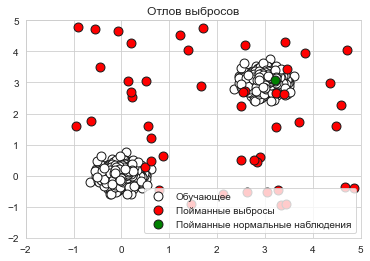

In [359]:
X_outliers = X_outliers.assign(y = y_pred_outliers)

plt.title("Отлов выбросов")

p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k')
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k')
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k')

plt.axis('tight')
plt.xlim((-2, 5))
plt.ylim((-2, 5))
plt.legend([p1, p2, p3],
           ["Обучающее",
            "Пойманные выбросы", 
            "Пойманные нормальные наблюдения"],
           loc="lower right")


plt.show()

[Читать](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) про IsolationForest в sklearn

# Extended Isolation Forest

Конечно, любой метод можно попытаться "докрутить", IsolationForest доработали [тут](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)

**Зачем**

Если ваш набор точек имеет некоторую сложную структуру, обработать ее с помощью линий, параллельных осям координат может оказаться непросто даже для двумерного случая. Примеры разброса точек:

<img src="https://github.com/sahandha/eif/raw/master/figures/Training.png">

Тепловая карта скора, полученного стандартным IsolationForest:

<img src="https://github.com/sahandha/eif/raw/master/figures/scores_maps.png">

Видно, что многое перемешалось.

Давайте вместо линий(гиперплоскостей), параллельных осям будем набрасывать просто случайные гиперплоскости(без условия параллельности осям).

Тогда наши разбиения плоскостями примут вид:
<img src="https://github.com/sahandha/eif/raw/master/figures/Ex1.png">

In [133]:
!pip install eif

     |████████████████████████████████| 1.6 MB 1.6 MB/s eta 0:00:01
  Created wheel for eif: filename=eif-2.0.2-cp38-cp38-macosx_10_9_x86_64.whl size=52851 sha256=9b58f5236f85cb2d00893a78c090a9fb6bb08cdd6d3565c72c825543d061fa49
  Stored in directory: /Users/i.pile/Library/Caches/pip/wheels/09/03/7b/a12d773555eff50431637ce26cbcc2b1b9c582c8b09b2d8350
Successfully built eif


In [360]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed

Сделаем два кластера точек

In [361]:
mean1 = [10, 0]
cov1 = [[1, 0], [0, 1]]  

mean2 = [0, 10]
cov2 = [[1, 0], [0, 1]]

Nobjs = 500          # Сколько точек брать
np.random.seed(1)    

x1, y1 = np.random.multivariate_normal(mean1, cov1, int(Nobjs/2)).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, int(Nobjs/2)).T

# Собираем в один датасет
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
X=np.array([x,y]).T

Картиночка

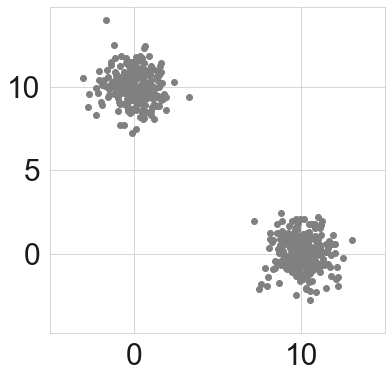

In [362]:
fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o', color=[0.5,0.5,0.5])
plt.grid("off")
plt.axis("equal")

plt.xlim([-5,15])
plt.ylim([-5,15])
plt.tick_params(direction='out', length=6, width=2, colors='k',labelsize=30)

plt.show()

Сравним результаты от обычного леса и "улучшенного"

In [363]:
F0  = iso.iForest(X,ntrees=500, sample_size=256, ExtensionLevel=0)
F1  = iso.iForest(X,ntrees=500, sample_size=256, ExtensionLevel=1)

In [364]:
# Скорим обучающую выборку
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)

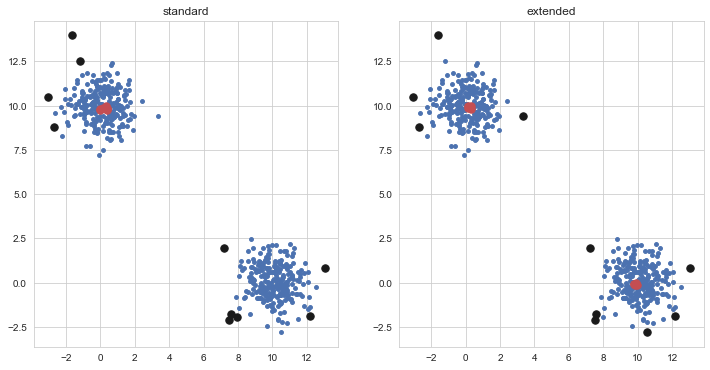

In [365]:
ss0=np.argsort(S0)
ss1=np.argsort(S1)

f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='k')
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r')
plt.title('standard')

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='k')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('extended')
plt.show()

Давайте теперь нарисуем тепловую карту скоров. 

In [367]:
xx, yy = np.meshgrid(np.linspace(-5, 15, 30), np.linspace(-5, 15, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

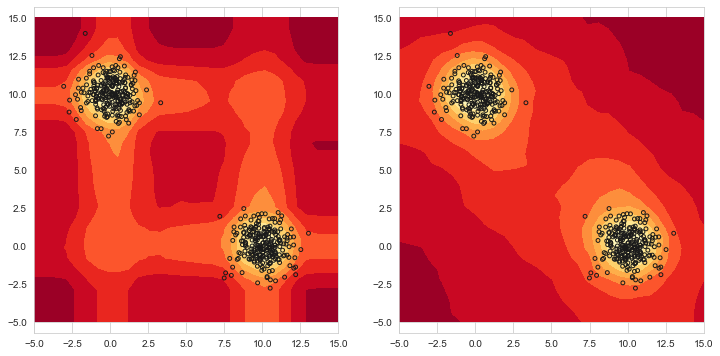

In [368]:
f = plt.figure(figsize=(12,6))

ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")


plt.show()

А как еще бывает?

Например есть библиотека PyOD. Примеры [здесь](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)

[Одноклассовый SVM](https://towardsdatascience.com/outlier-detection-with-one-class-svms-5403a1a1878c)